# 1. Загрузка данных

Используются данные с курса "Симулятор аналитика" Karpov Courses (https://karpov.courses/simulator)

In [ ]:
import pandas as pd
import numpy as np
import pandahouse as ph
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [ ]:
rng = np.random.default_rng(42)

In [ ]:
import orbit
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components

In [ ]:
#задаем параметры подключения к СУБД clickhouse
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20250920',
'user':'student',
'password':'dpo_python_2020'
}

In [ ]:
# делаем запрос в sql
query = '''
with new_users as
(select start_time as date, count(user_id) as new_users
from (
select user_id, min(toDate(time)) as start_time
from {db}.feed_actions
group by user_id) t
group by date)

select toDate(time) as date,
       count(distinct user_id) as DAU,
       countIf(action='like') as likes,
       countIf(action='view') as views,
       likes/views as CTR,
       max(n.new_users) as new_users,
       count(distinct post_id) as unique_posts
from {db}.feed_actions f
left join new_users n using(date)
group by date

'''
df = ph.read_clickhouse(query, connection=connection)

In [ ]:
df

,date,DAU,likes,views,CTR,new_users,unique_posts
0,2025-08-06,878,1560,7603,0.205182,878,89
1,2025-08-07,2238,12816,62770,0.204174,1819,178
2,2025-08-08,3105,20958,105526,0.198605,1849,191
3,2025-08-09,3721,23800,118996,0.200007,1652,211
4,2025-08-10,4617,34504,174454,0.197783,1809,214
...,...,...,...,...,...,...,...
63,2025-10-08,19554,182190,833754,0.218518,1304,217
64,2025-10-09,19572,164565,744881,0.220928,1338,200
65,2025-10-10,19768,154251,710587,0.217075,1580,200
66,2025-10-11,19363,147718,719064,0.205431,1084,213


# 2. Анализ данных для построения моделей

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

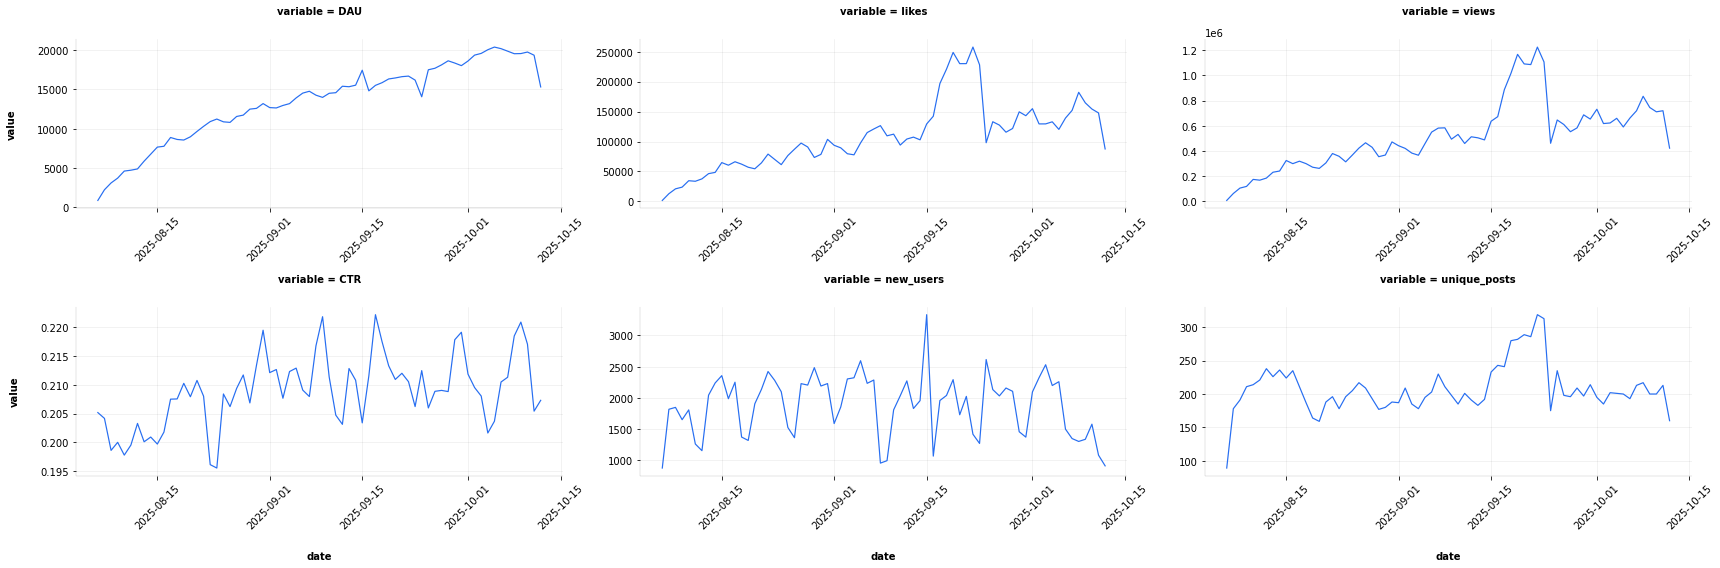

In [ ]:
from orbit.eda.eda_plot import wrap_plot_ts
wrap_plot_ts(df, "date", list(df.columns))

1. В качестве основной метрики для определения нагрузки на сервер будем использовать количество активных юзеров DAU. Временное разрешение - день
2. Из графика можно предположить, что показатель "new_users" влияет на значения "DAU", значит в последствии сможем использовать его в качестве регрессора.

In [ ]:
corr = df['DAU'].corr(df['new_users'])
print("Корреляция DAU и new_users:", corr)

Корреляция DAU и new_users: 0.09644031061384854


# 3. Модели без регрессора

# 3.1 Maximum a Posteriori (MAP)

In [ ]:
dlt = DLT(response_col="DAU", #название колонки с метрикой
          date_col="date", #название колонки с датами-временем
          seasonality=7, #длина периода сезонности
          estimator="stan-map", #алгоритм оценки
          n_bootstrap_draws=1000) #количество сэмплов бутстрапа для доверительного интервала

2025-10-12 13:02:12 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


In [ ]:
dlt.fit(df)

2025-10-12 13:02:15 - orbit - INFO - First time in running stan model:dlt. Expect 3 - 5 minutes for compilation.


In [ ]:
future_df = dlt.make_future_df(periods=7*4)

In [ ]:
predicted_dlt = dlt.predict(df=future_df)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

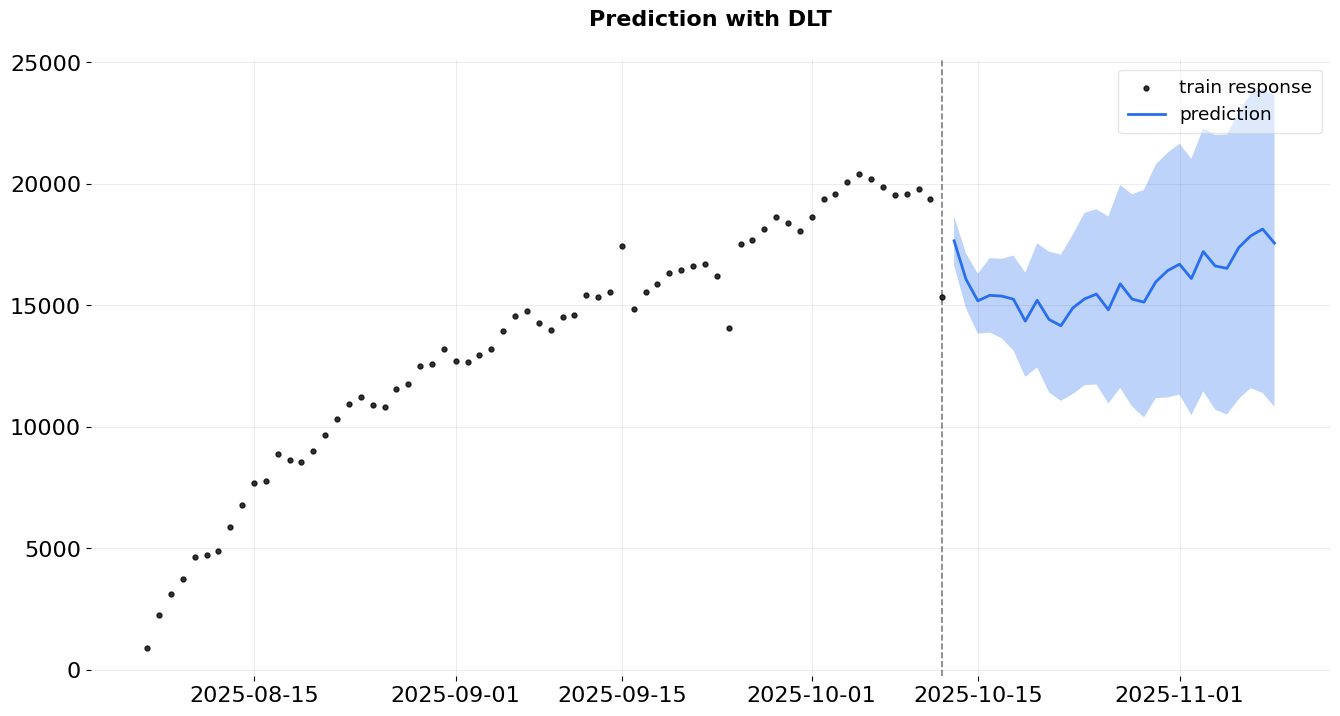

In [ ]:
_ = plot_predicted_data(df, #изначальные данные
                        predicted_dlt, #датафрейм с предсказаниями
                        "date", #колонка со временем
                        'DAU', #колонка со значениями временного ряда
                        title='Prediction with DLT') #заголовок рисунка

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

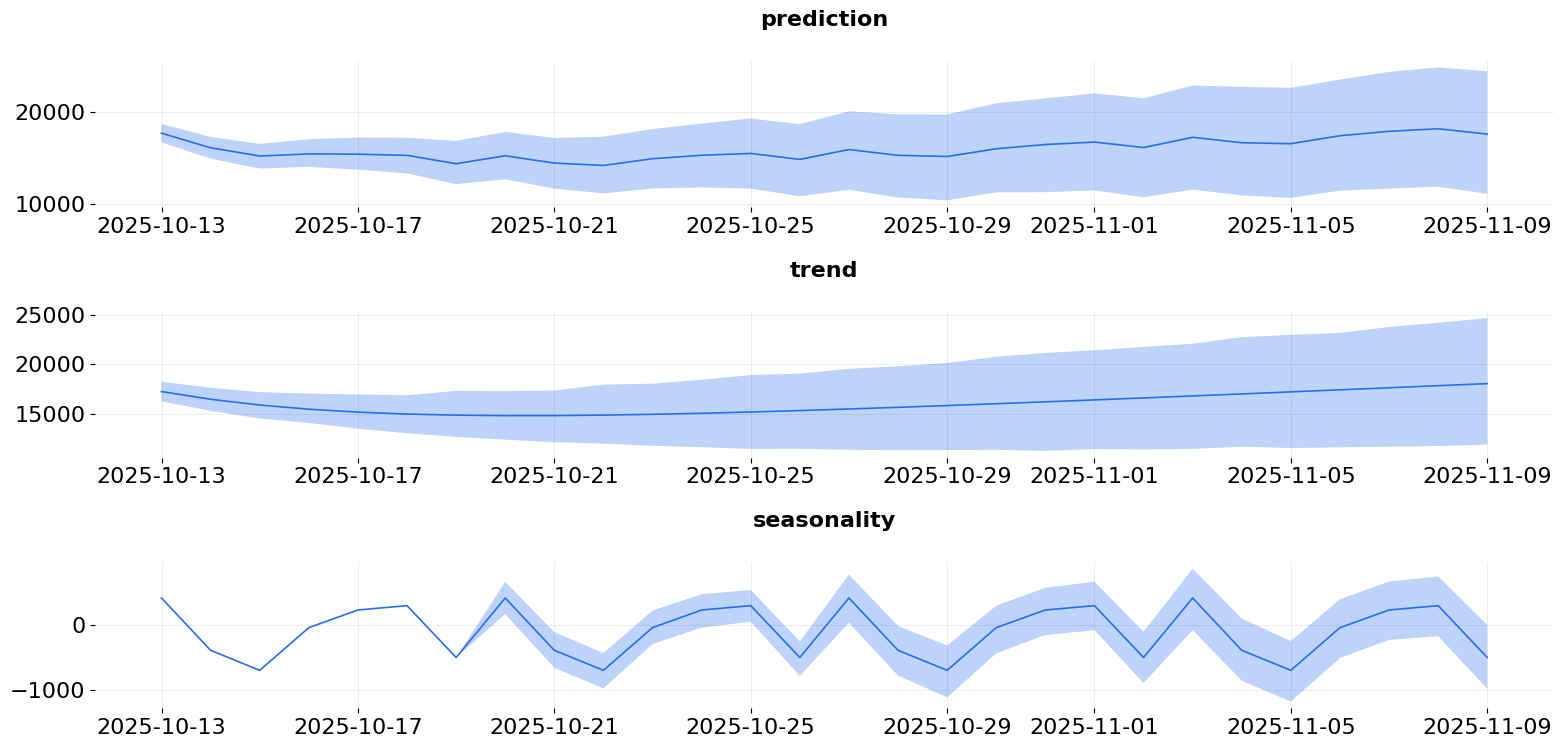

In [ ]:
predicted_df = dlt.predict(df=future_df,
                           decompose=True) #говорит, что нам нужна декомпозиция предсказания

_ = plot_predicted_components(predicted_df,
                              "date",
                              plot_components=['prediction', 'trend', 'seasonality'])

Проверим качество модели

In [ ]:
num_cols = ['DAU', 'likes', 'views', 'CTR', 'unique_posts', 'new_users']
df[num_cols] = df[num_cols].astype(float)

In [ ]:
from orbit.diagnostics.backtest import BackTester #основной класс для бэктестинга

bt_exp = BackTester(
    model = dlt, #наша моделька
    df = df, #датафрейм для обучения
    min_train_len = 7*3, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len = 2, #на сколько происходит прирост тренировочных данных
    forecast_len = 7, #горизонт прогнозирования
    window_type = "expanding" #тип окошка
)

In [ ]:
bt_exp.fit_predict() #обучаем
bt_exp.score() #выводим метрики

,metric_name,metric_values,is_training_metric
0,smape,5.933097e-02,False
1,wmape,5.932175e-02,False
2,mape,6.123259e-02,False
3,mse,1.556129e+06,False
4,mae,9.654901e+02,False
5,rmsse,1.187911e+00,False


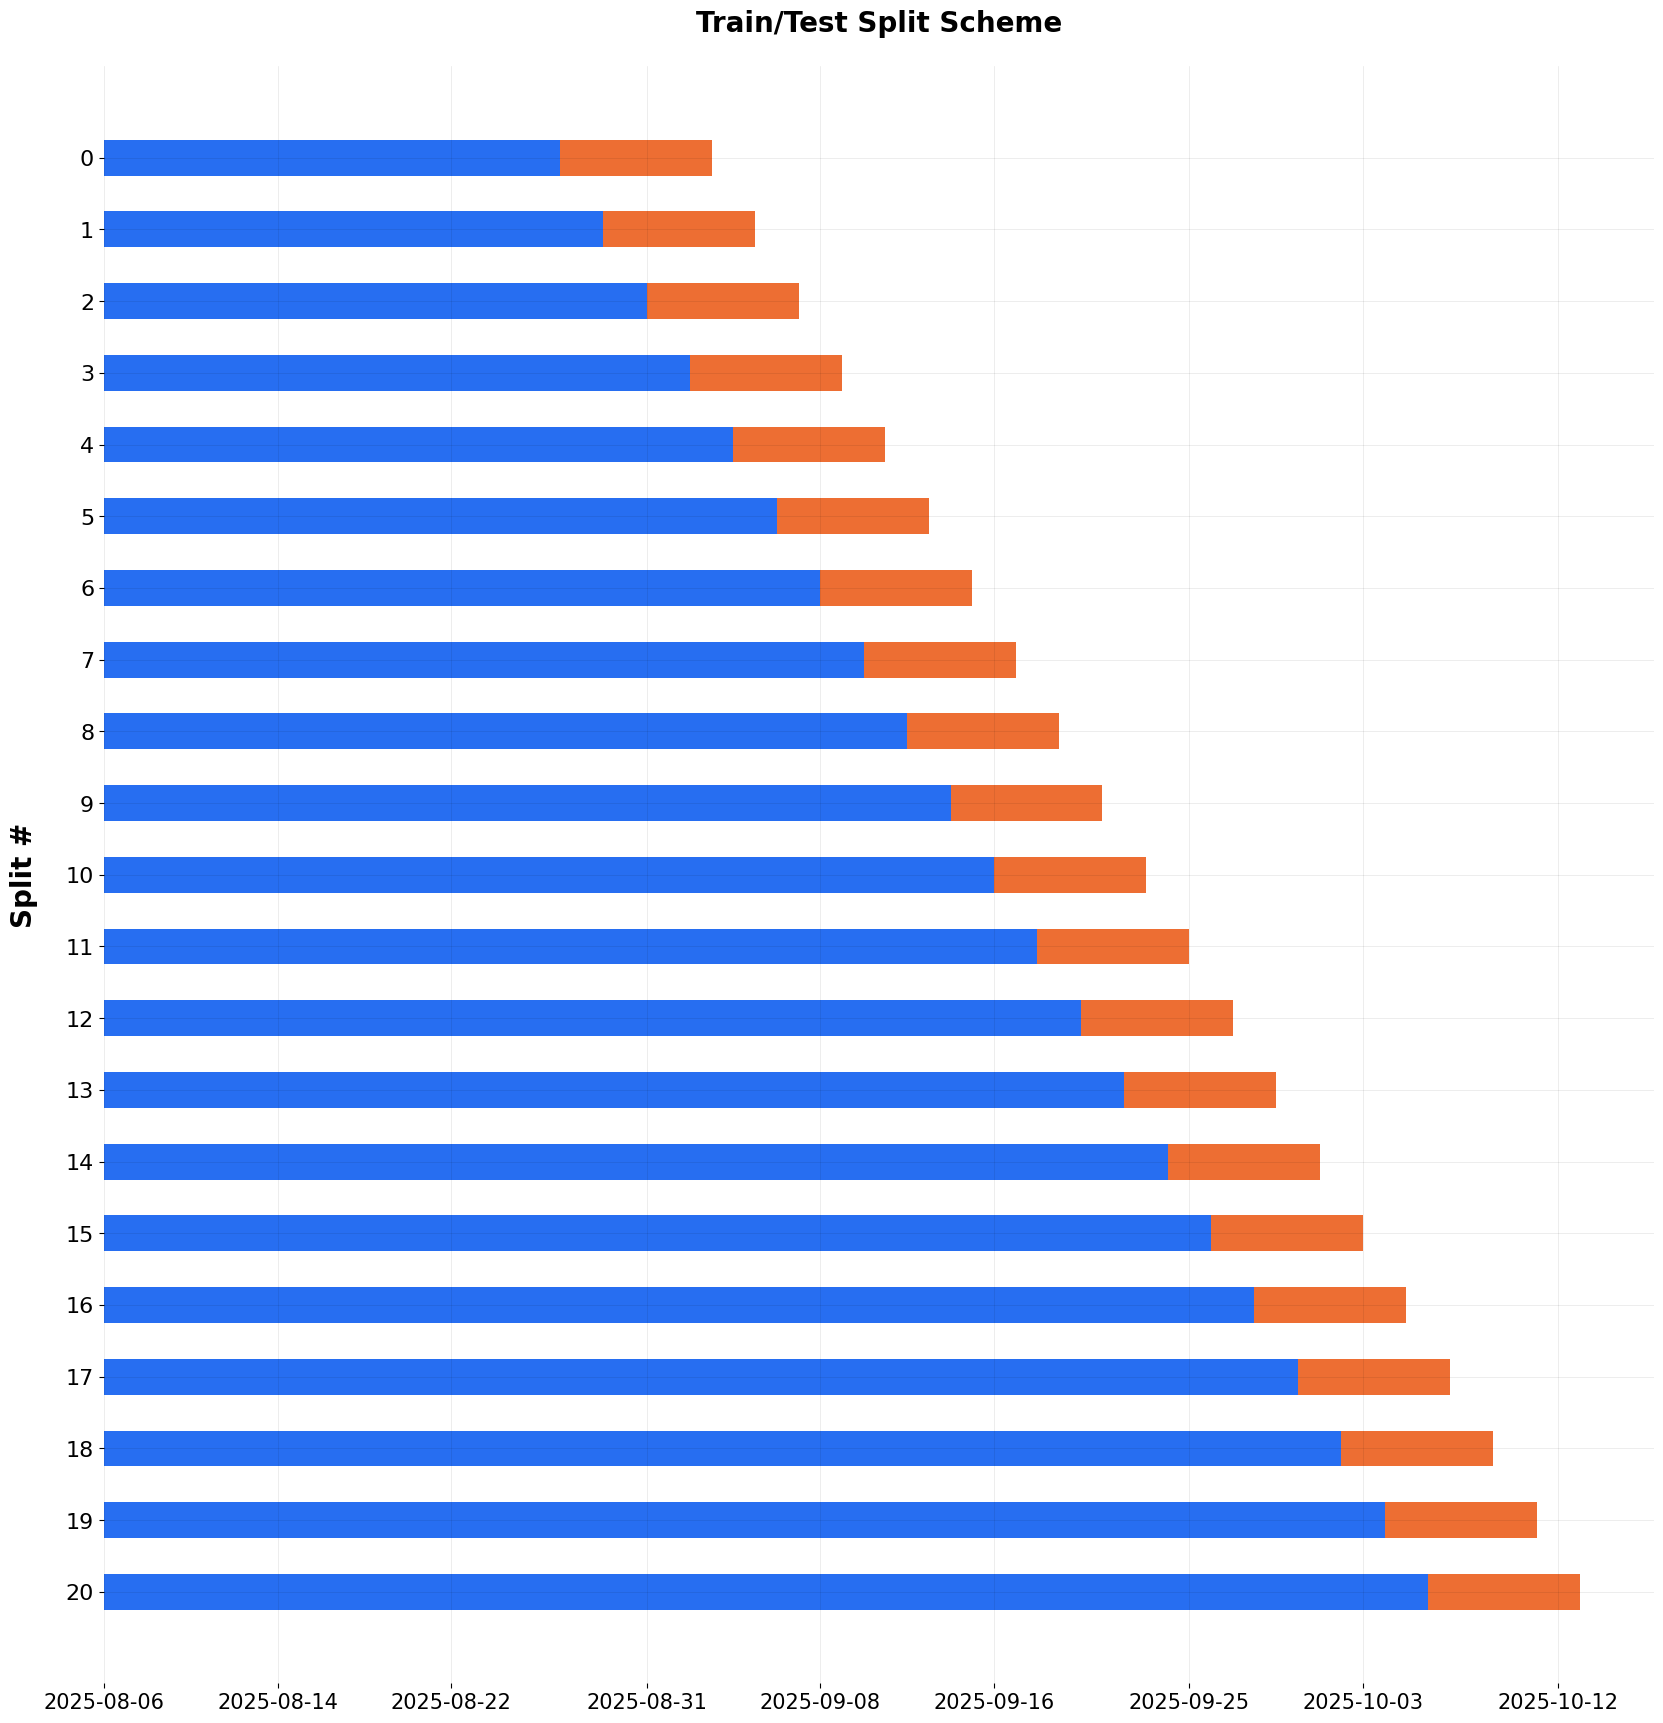

In [ ]:
bt_exp.plot_scheme()

Построим модель LGT и проверим ее качество

In [ ]:
from orbit.models import LGT

2025-10-12 13:07:22 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2025-10-12 13:07:22 - orbit - INFO - First time in running stan model:lgt. Expect 3 - 5 minutes for compilation.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the foll

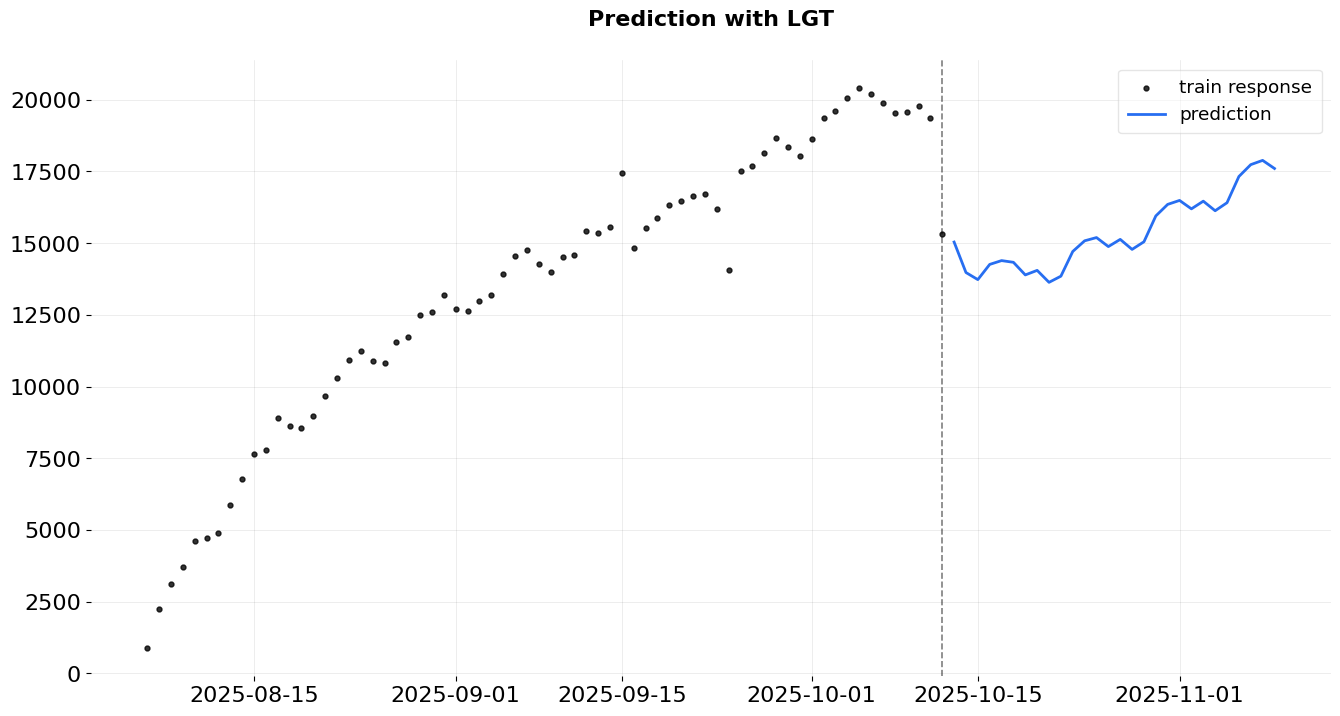

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

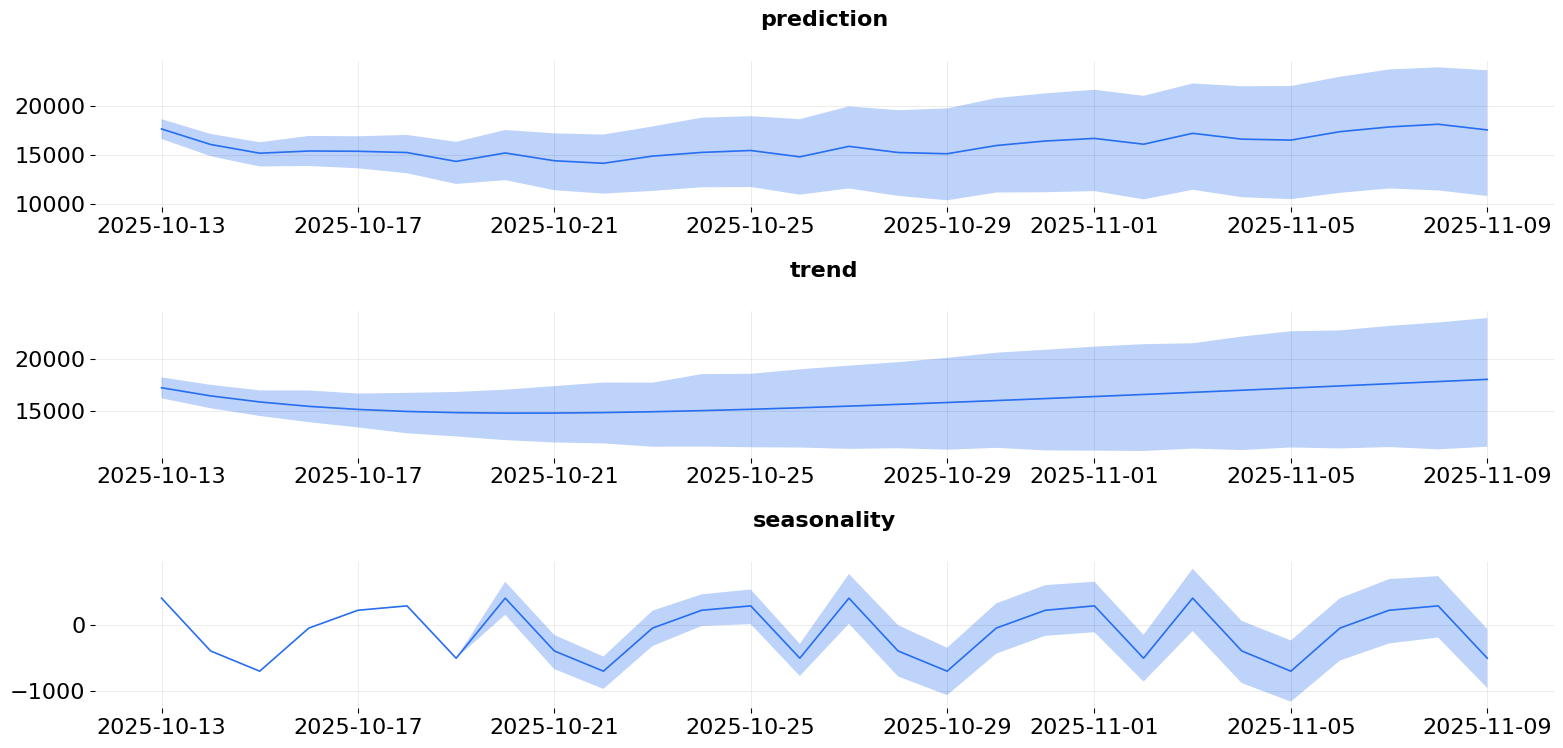

,metric_name,metric_values,is_training_metric
0,smape,5.742325e-02,False
1,wmape,5.787060e-02,False
2,mape,5.925549e-02,False
3,mse,1.959924e+06,False
4,mae,9.418720e+02,False
5,rmsse,1.333155e+00,False


In [ ]:
# задаем параметры для модели
lgt = LGT(response_col="DAU",
          date_col="date",
          seasonality=7,
          estimator="stan-map",
          seed=8888)
lgt.fit(df)
future_df = lgt.make_future_df(periods=7*4)
predicted_lgt = lgt.predict(df=future_df)

# строим графики полученных результатов
_ = plot_predicted_data(df,
                        predicted_lgt,
                        "date",
                        'DAU',
                        title='Prediction with LGT')

predicted_df = dlt.predict(df=future_df,
                           decompose=True)

_ = plot_predicted_components(predicted_df,
                              "date",
                              plot_components=['prediction', 'trend', 'seasonality'])
# оцениваем качество работы модели
bt_exp = BackTester(
    model = lgt,
    df = df,
    min_train_len = 7*3,
    incremental_len = 2,
    forecast_len = 7, #горизонт прогнозирования
    window_type = "expanding" #тип окошка
)
bt_exp.fit_predict()
bt_exp.score()

LGT дает меньшую ошибку, результаты похожи на модель DLT.

# 3.2 Markov Chain Monte Carlo (MCMC)

Теперь посмотрим, как работает модель с алгоритмом марковских цепей

2025-10-12 13:10:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

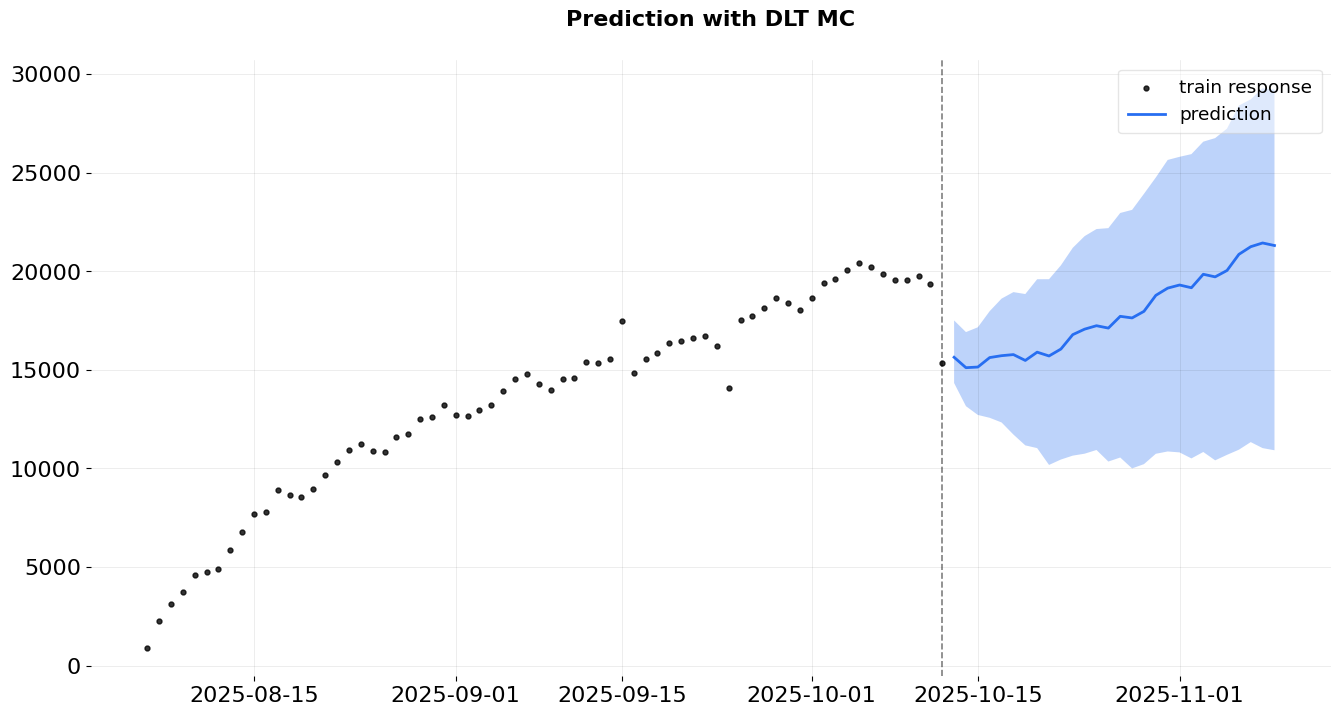

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

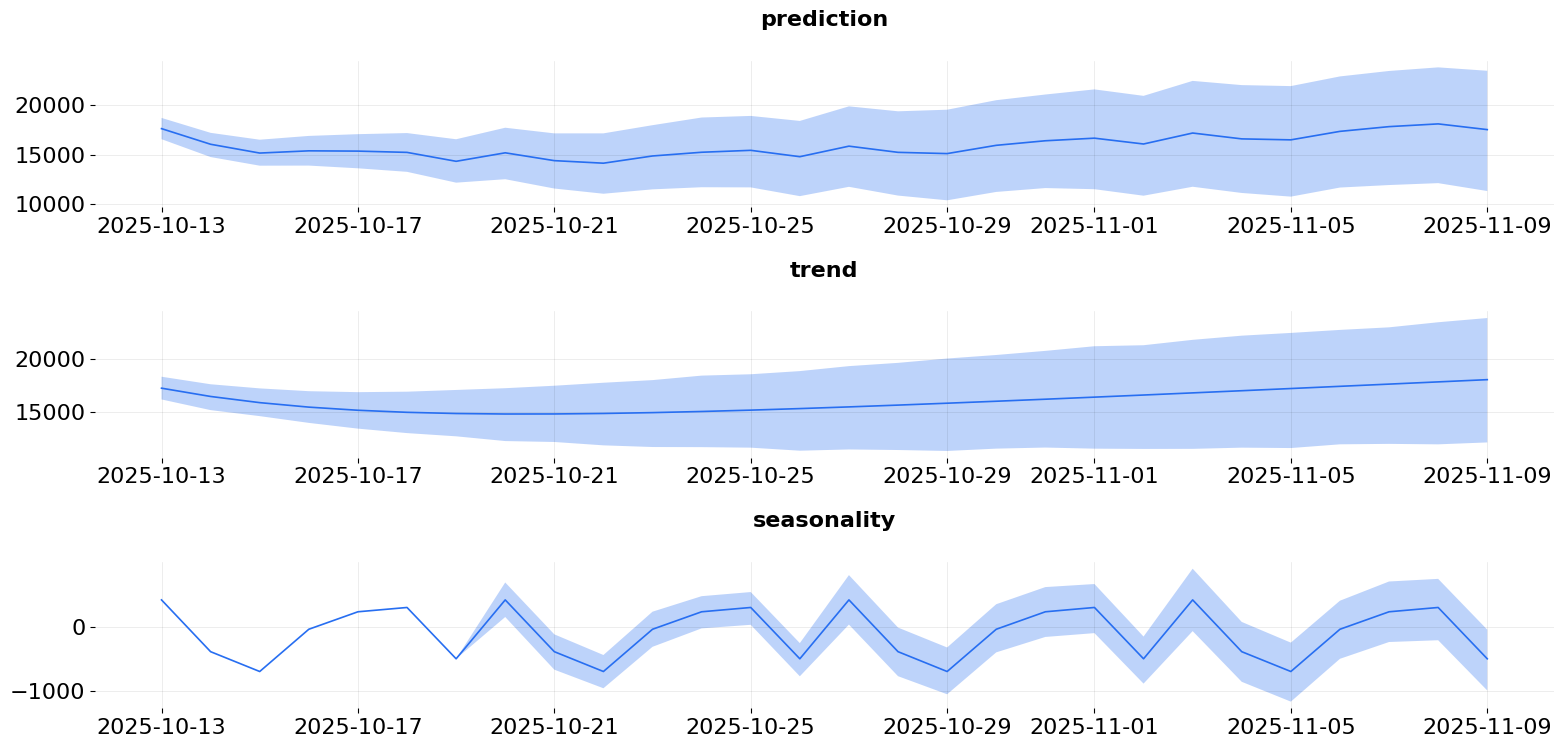

2025-10-12 13:10:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-10-12 13:10:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-10-12 13:10:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-10-12 13:10:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-10-12 13:10:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-10-12 13:10:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-10-12 13:10:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-10-12 13:10:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-10-12 13:10:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-10-12 13:10:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-10-12 13:10:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-10-12 13:10:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-10-12 13:10:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-10-12 13:10:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-10-12 13:10:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-10-12 13:10:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-10-12 13:10:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-10-12 13:10:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-10-12 13:10:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-10-12 13:11:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-10-12 13:11:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

,metric_name,metric_values,is_training_metric
0,smape,5.615070e-02,False
1,wmape,5.755614e-02,False
2,mape,5.899481e-02,False
3,mse,1.782301e+06,False
4,mae,9.367539e+02,False
5,rmsse,1.271311e+00,False


In [ ]:
# задаем параметры для модели
dlt_mc = DLT(response_col="DAU",
          date_col="date",
          seasonality=7,
          estimator="stan-mcmc", # выбираем алгоритм марковских цепей
          n_bootstrap_draws=1000)
dlt_mc.fit(df)
future_df = dlt_mc.make_future_df(periods=7*4)
predicted_dlt_mc = dlt_mc.predict(df=future_df)

# строим графики полученных результатов
_ = plot_predicted_data(df,
                        predicted_dlt_mc,
                        "date",
                        'DAU',
                        title='Prediction with DLT MC')

predicted_df = dlt.predict(df=future_df,
                           decompose=True)

_ = plot_predicted_components(predicted_df,
                              "date",
                              plot_components=['prediction', 'trend', 'seasonality'])
# оцениваем качество работы модели
bt_exp = BackTester(
    model = dlt_mc,
    df = df,
    min_train_len = 7*3,
    incremental_len = 2,
    forecast_len = 7, #горизонт прогнозирования
    window_type = "expanding" #тип окошка
)
bt_exp.fit_predict()
bt_exp.score()

Видим, что "sample commited", значит цепи сошлись к одному результату и модель работает.

/opt/conda/lib/python3.8/site-packages/arviz/data/base.py:221: UserWarning: More chains (100) than draws (67). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/data/base.py:221: UserWarning: More chains (100) than draws (74). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/data/base.py:221: UserWarning: More chains (100) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/data/base.py:221: UserWarning: More chains (100) than draws (66). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.8/site-packages/arv

array([[<Axes: title={'center': 'l'}>, <Axes: title={'center': 'l'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'lev_sm'}>,
        <Axes: title={'center': 'lev_sm'}>],
       [<Axes: title={'center': 'slp_sm'}>,
        <Axes: title={'center': 'slp_sm'}>],
       [<Axes: title={'center': 'obs_sigma'}>,
        <Axes: title={'center': 'obs_sigma'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>],
       [<Axes: title={'center': 'lt_sum'}>,
        <Axes: title={'center': 'lt_sum'}>],
       [<Axes: title={'center': 's'}>, <Axes: title={'center': 's'}>],
       [<Axes: title={'center': 'sea_sm'}>,
        <Axes: title={'center': 'sea_sm'}>],
       [<Axes: title={'center': 'gt_sum'}>,
        <Axes: title={'center': 'gt_sum'}>],
       [<Axes: title={'center': 'gb'}>, <Axes: title={'center': 'gb'}>],
       [<Axes: title={'center': 'gl'}>, <Axes: title={'center': 'gl'}>],
       [<Axes: title={'cente

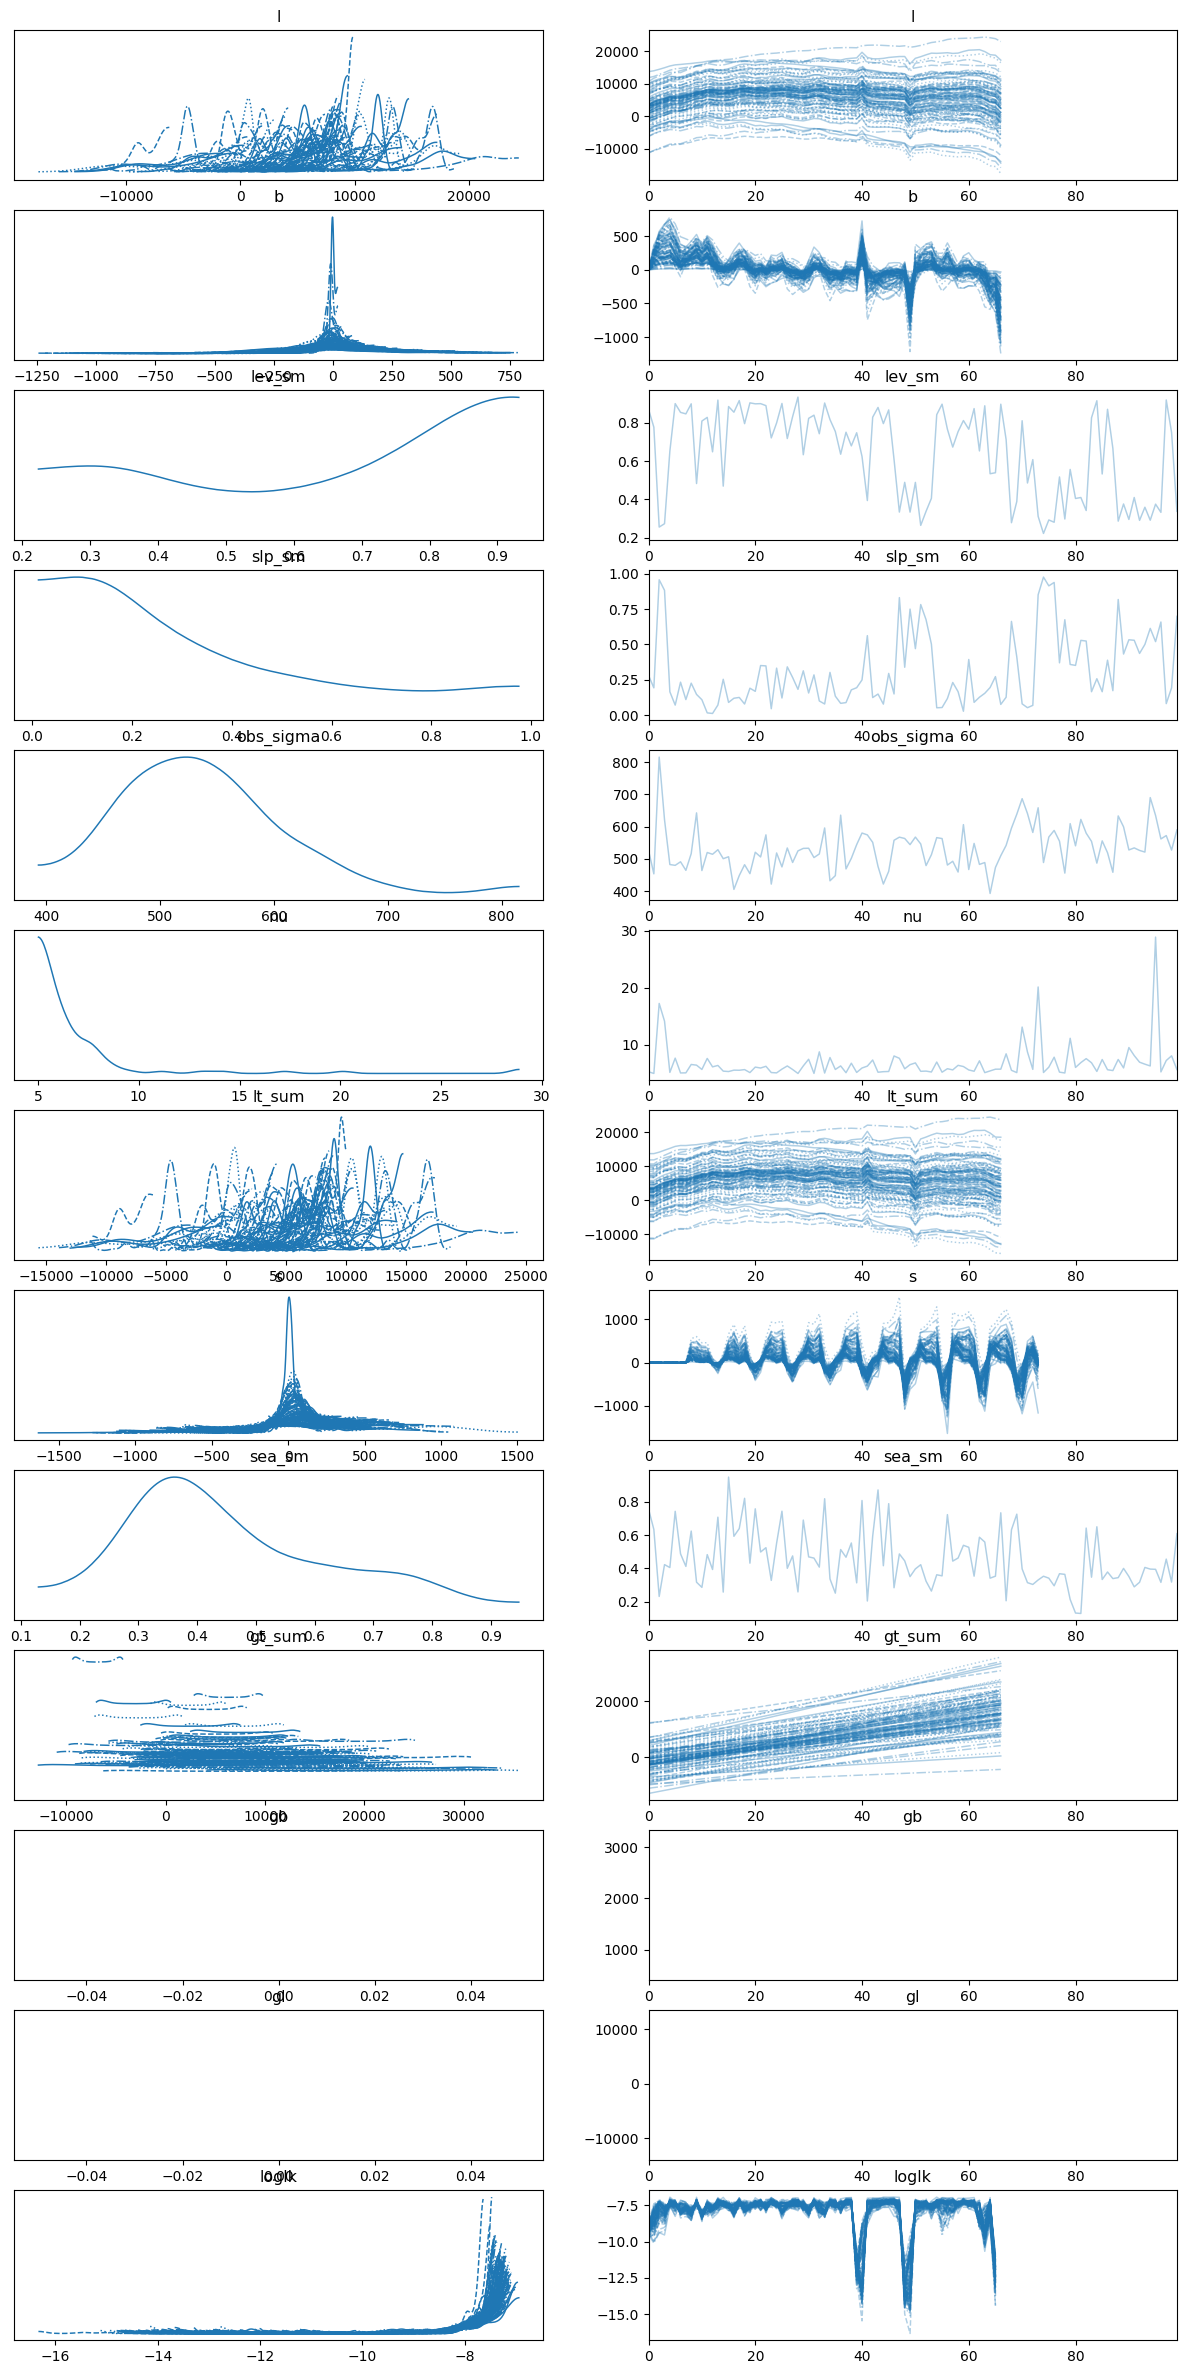

In [ ]:
import arviz as az # импортируем библиотеку дял визуализации, которая работает с орбит
posterior_samples = dlt_mc.get_posterior_samples() # достаем параметры марковских цепей, чтобы наглядно посмотреть на работу алгоритма
idata = az.from_dict(posterior=posterior_samples)
az.plot_trace(idata, figsize=(15, 30))

Видно, что линии сходятся к какому-то среднему значению (интервалу).

# 3.3 Variational Inference (VI)

Теперь проверим, как работает алгоритм Variational Inference

In [ ]:
import orbit.models
dir(orbit.models) # cмотрим какие модели есть в библиотеке, чтоб подобрать подъодящую для использования VI

['DLT',
 'ETS',
 'KTR',
 'KTRLite',
 'LGT',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'dlt',
 'ets',
 'ktr',
 'ktrlite',
 'lgt']

In [ ]:
from orbit.models import KTR # будем использовать KTR

In [ ]:
help(KTR)

Help on function KTR in module orbit.models.ktr:

KTR(level_knot_scale=0.1, level_segments=10, level_knot_distance=None, level_knot_dates=None, seasonality=None, seasonality_fs_order=None, seasonality_segments=3, seasonal_initial_knot_scale=1.0, seasonal_knot_scale=0.1, regressor_col=None, regressor_sign=None, regressor_init_knot_loc=None, regressor_init_knot_scale=None, regressor_knot_scale=None, regression_segments=5, regression_knot_distance=None, regression_knot_dates=None, regression_rho=0.15, degree_of_freedom=30, date_freq=None, coef_prior_list=None, flat_multiplier=True, residuals_scale_upper=None, ktrlite_optim_args={}, estimator='pyro-svi', **kwargs)
    Parameters
    ----------
    level_knot_scale : float
        sigma for level; default to be .1
    level_segments : int
        the number of segments partitioned by the knots of level (trend)
    level_knot_distance : int
        the distance between every two knots of level (trend)
    level_knot_dates : array like
      

2025-10-12 13:14:20 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2025-10-12 13:14:20 - orbit - INFO - First time in running stan model:ktrlite. Expect 3 - 5 minutes for compilation.
2025-10-12 13:15:07 - orbit - INFO - Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
2025-10-12 13:15:07 - orbit - INFO - step    0 loss = 825.47, scale = 0.09813
INFO:orbit:step    0 loss = 825.47, scale = 0.09813
2025-10-12 13:15:12 - orbit - INFO - step  100 loss = 803.06, scale = 0.29736
INFO:orbit:step  100 loss = 803.06, scale = 0.29736
2025-10-12 13:15:17 - orbit - INFO - step  200 loss = 803.15, scale = 0.29412
INFO:orbit:step  200 loss = 803.15, scale = 0.29412
2025-10-12 13:15:23 - orbit - INFO - step  300 loss = 803.37, scale = 0.31404
INFO:orbit:step  300 loss = 803.37, scale = 0.31404


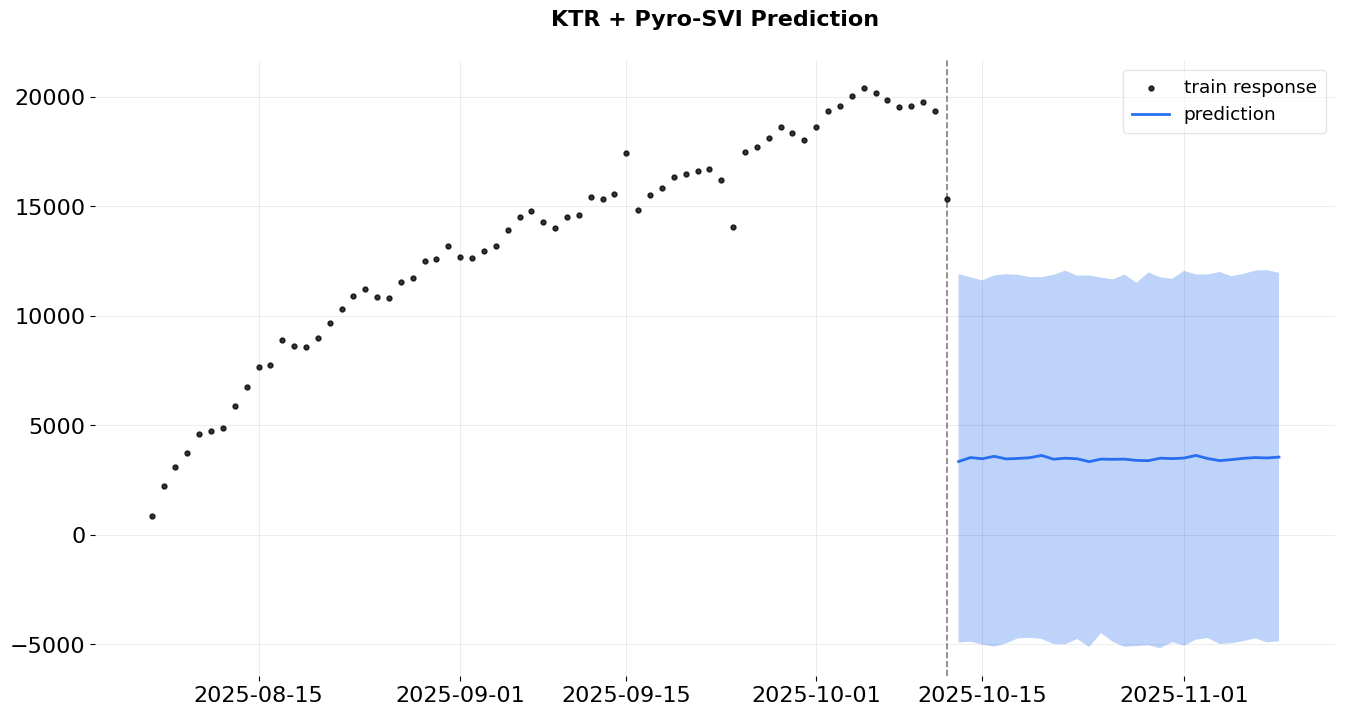

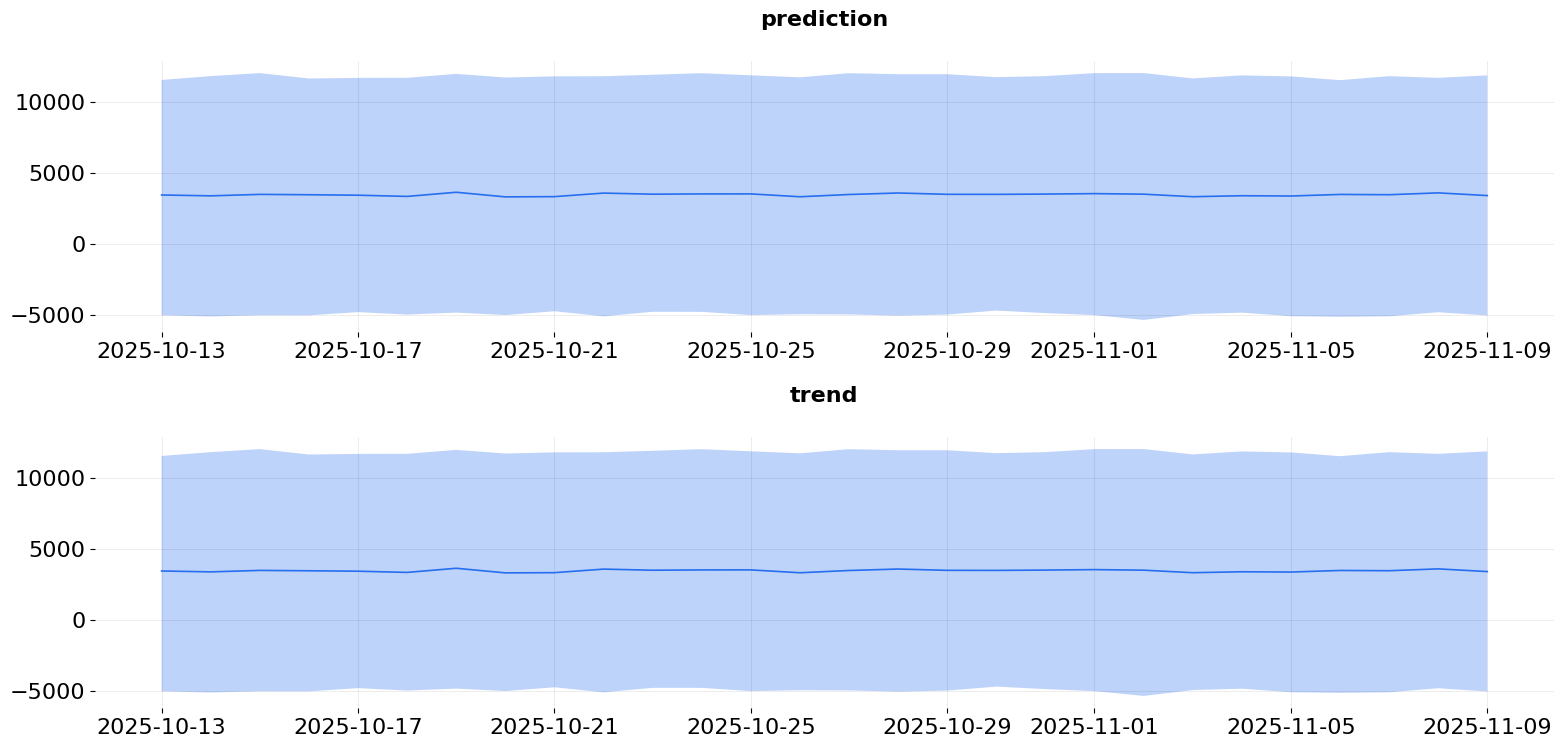

In [ ]:
# задаем параметры для модели
ktr_svi = KTR(
    response_col="DAU",
    date_col="date",
    level_knot_scale=0.1,
    seasonality_fs_order=3,
    seasonality=7,
    estimator="pyro-svi",         # используем SVI
    n_bootstrap_draws = 5000 ,    # количество итераций
    verbose=True                  # показывать прогресс
)
ktr_svi.fit(df)
future_df = ktr_svi.make_future_df(periods=7*4)
predicted_KTR = ktr_svi.predict(df=future_df)

# строим графики полученных результатов
_ = plot_predicted_data(df,
                        predicted_KTR,
                        "date",
                        'DAU',
                        title='KTR + Pyro-SVI Prediction')

predicted_df = ktr_svi.predict(df=future_df,
                           decompose=True)

_ = plot_predicted_components(predicted_df,
                              "date",
                              plot_components=['prediction', 'trend', 'seasonality'])


Судя по всему, оптимизация не сходится, поэтому модель «замораживает» прогноз на среднем уровне ряда.
Значит, не будем ее использовать.

# 4. Модели с регрессором

In [ ]:
# Из п.2 мы оценили, что в качестве регрессора можем использовать метрику 'new_users'

<Axes: >

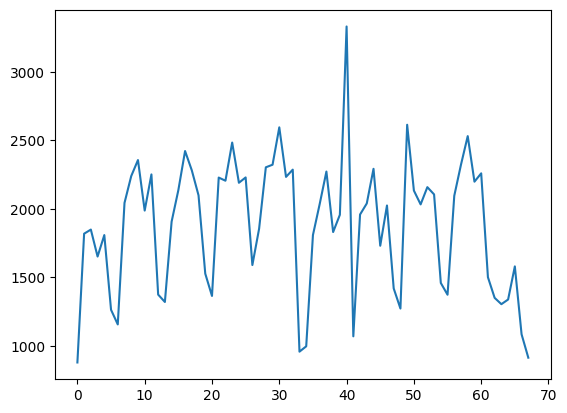

In [ ]:
df['new_users'].plot()

In [ ]:
# Сгенерируем на основе наших данных распределение 'new_users' на следующий месяц (30 дней)

In [ ]:
df['new_users'].mean()

1876.8970588235295

In [ ]:
# так как распределение новых юзеров меняется примерно в одном диапазоне, мы можем предположить, что оно останется таким же и смоделировать его на следующий месяц
new_users_distr = df[['date', 'new_users']]
new_users_distr ['p'] = df['new_users']/df['new_users'].sum()
new_users_distr.sort_values(by = 'p', ascending = False)

,date,new_users,p
40,2025-09-15,3333.0,0.026115
49,2025-09-24,2615.0,0.020489
30,2025-09-05,2596.0,0.020340
58,2025-10-03,2532.0,0.019839
23,2025-08-29,2485.0,0.019470
...,...,...,...
41,2025-09-16,1069.0,0.008376
34,2025-09-09,996.0,0.007804
33,2025-09-08,957.0,0.007498
67,2025-10-12,913.0,0.007154


In [ ]:
# смоделируем распределение новых пользователей на будующий период
users_distr = rng.choice(new_users_distr['new_users'], size = 30,
           replace=True, p=new_users_distr['p']) # случайная выборка на 30 дней
start_date = pd.Timestamp.today().normalize() + pd.Timedelta(days=1) # задаем стартовую дату для регрессора (завтра)
date_range = pd.date_range(start=start_date, periods=30, freq='D') # определяем тайм-рэндж для дата-фрейма (30 дней)
regr = pd.DataFrame(
    {'new_users': users_distr},
    index=pd.Index(date_range, name='date')  # задаем имя индекса сразу
) # создаем регрессор - предпологаемое распределение новых юзеров на следующий месяц
regr

,new_users
date,
2025-10-13,2615.0
2025-10-14,1338.0
2025-10-15,2206.0
2025-10-16,2230.0
2025-10-17,2234.0
2025-10-18,1907.0
2025-10-19,2357.0
2025-10-20,2234.0
2025-10-21,2423.0


new_users    2027.666667
dtype: float64

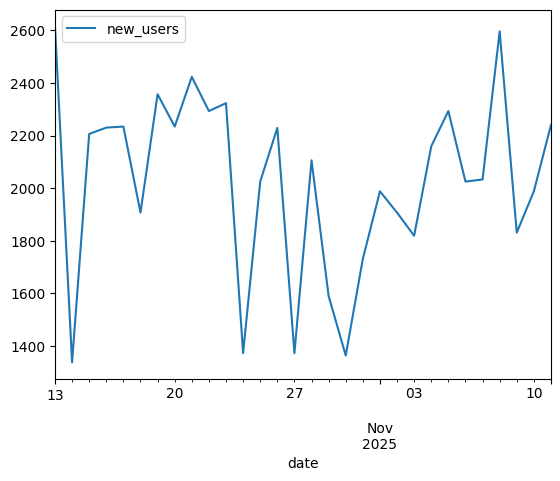

In [ ]:
regr.plot()
regr.mean()

In [ ]:
# полученное распределение похоже на реальные данные, поэтому можем его использовать

2025-10-12 13:21:13 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


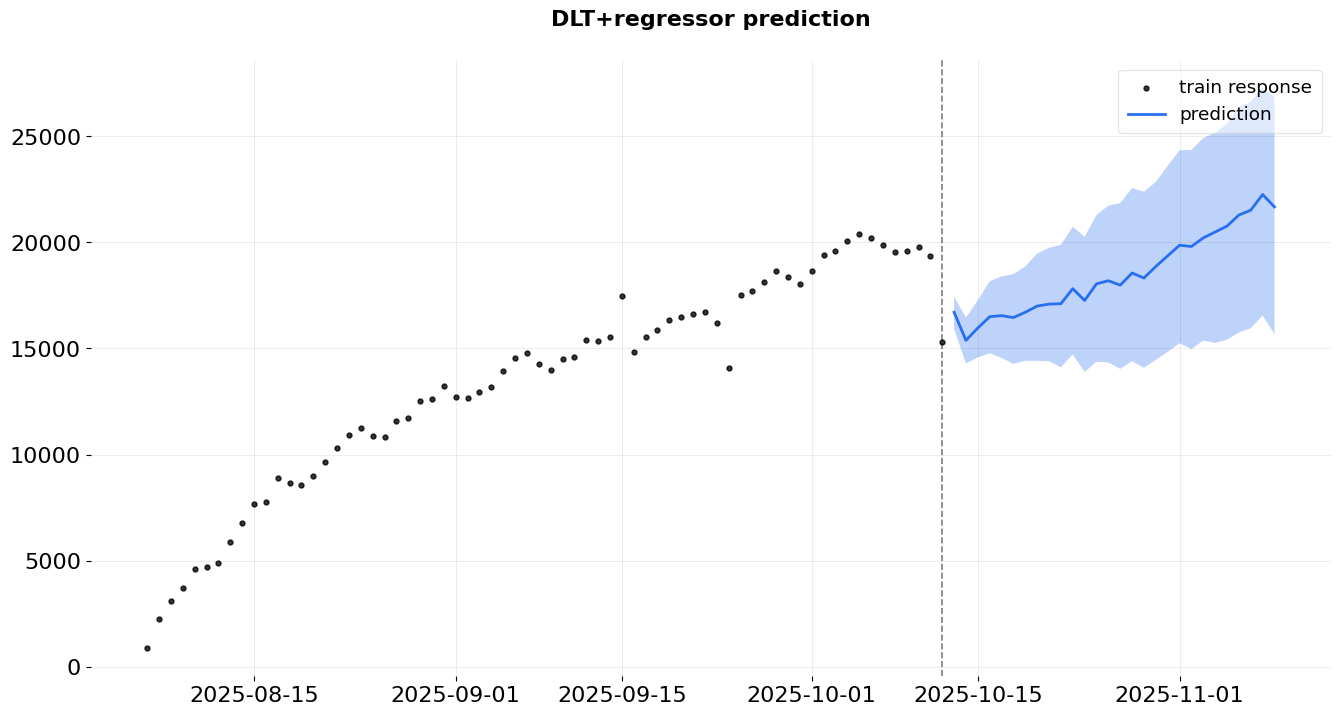

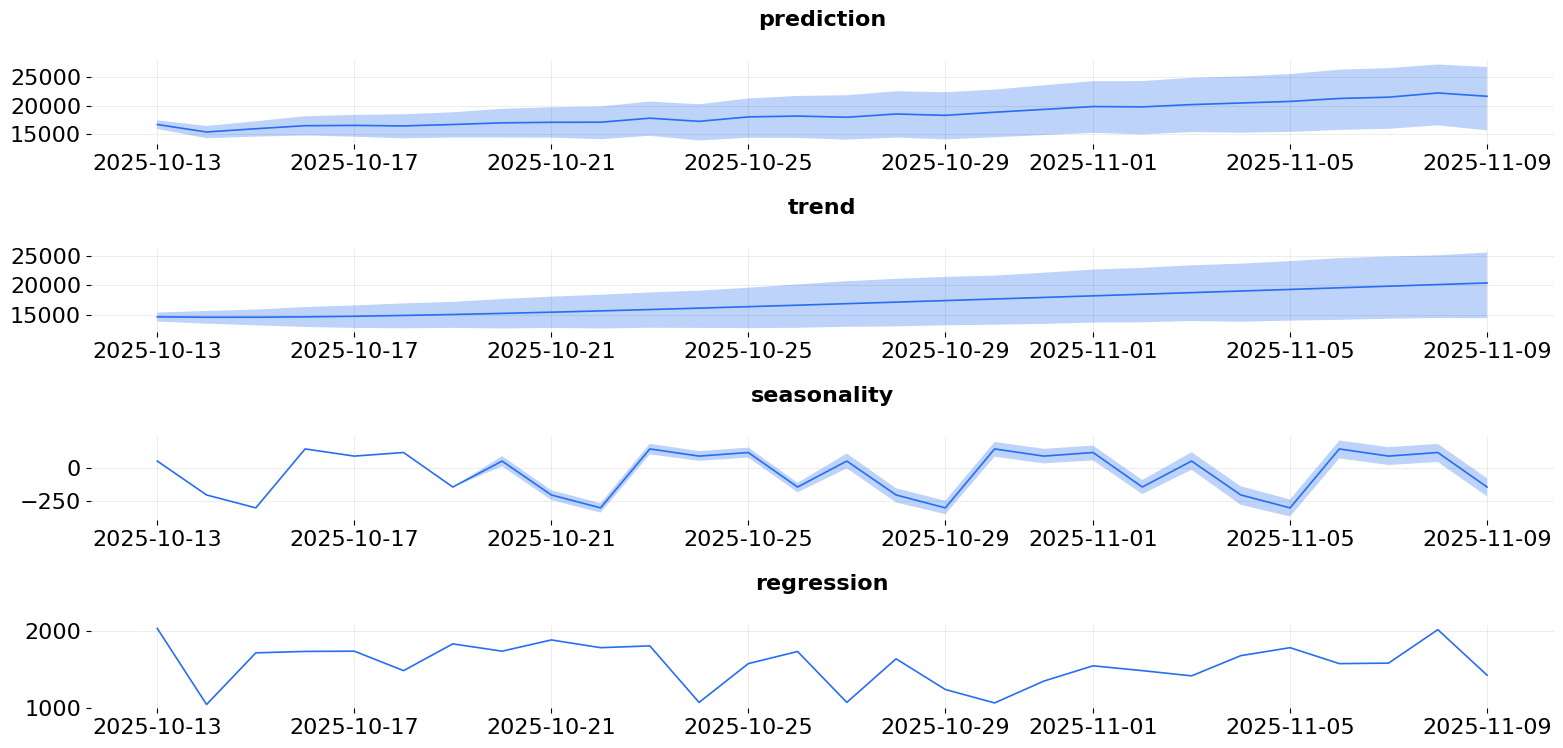

,metric_name,metric_values,is_training_metric
0,smape,5.090699e-02,False
1,wmape,5.147722e-02,False
2,mape,5.272881e-02,False
3,mse,1.461433e+06,False
4,mae,8.378166e+02,False
5,rmsse,1.151199e+00,False


In [ ]:
# строим модель DLT с регрессором
dlt_regr = DLT(response_col="DAU", #название колонки с метрикой
          date_col="date", #название колонки с датами-временем
          regressor_col= ["new_users"],
          seasonality=7, #длина периода сезонности
          estimator="stan-map", #алгоритм оценки
          n_bootstrap_draws=1000) #количество сэмплов бутстрапа для доверительного интервала

dlt_regr.fit(df)
future_df = dlt_regr.make_future_df(periods=7*4)
future_df = future_df.merge(regr, on='date', how='left') # добавляем колонку с регрессором в указанный файл через джойн и проверяем, что он появился
future_df['new_users'] = future_df['new_users'].astype(float) # переводим тип данных для возможности работы модели
predicted_dlt_regr = dlt_regr.predict(df=future_df, decompose=True) # прогнозируем данные с учетом регрессора

_ = plot_predicted_data(df,
                        predicted_dlt_regr,
                        "date",
                        'DAU',
                        title='DLT+regressor prediction')

_ = plot_predicted_components(predicted_dlt_regr,
                              "date",
                              plot_components=['prediction', 'trend', 'seasonality', 'regression'])

# оцениваем качество работы модели
bt_exp = BackTester(
    model = dlt_regr,
    df = df,
    min_train_len = 7*3,
    incremental_len = 2,
    forecast_len = 7,
    window_type = "expanding"
)
bt_exp.fit_predict()
bt_exp.score()

Модель отреагировала на регрессор и изменила значения метрики. Ошибка снизилась (mape для DLT без регрессора = 6.123259e-02).
Посмотрим, что будет для модели LGT.

2025-10-12 13:21:23 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


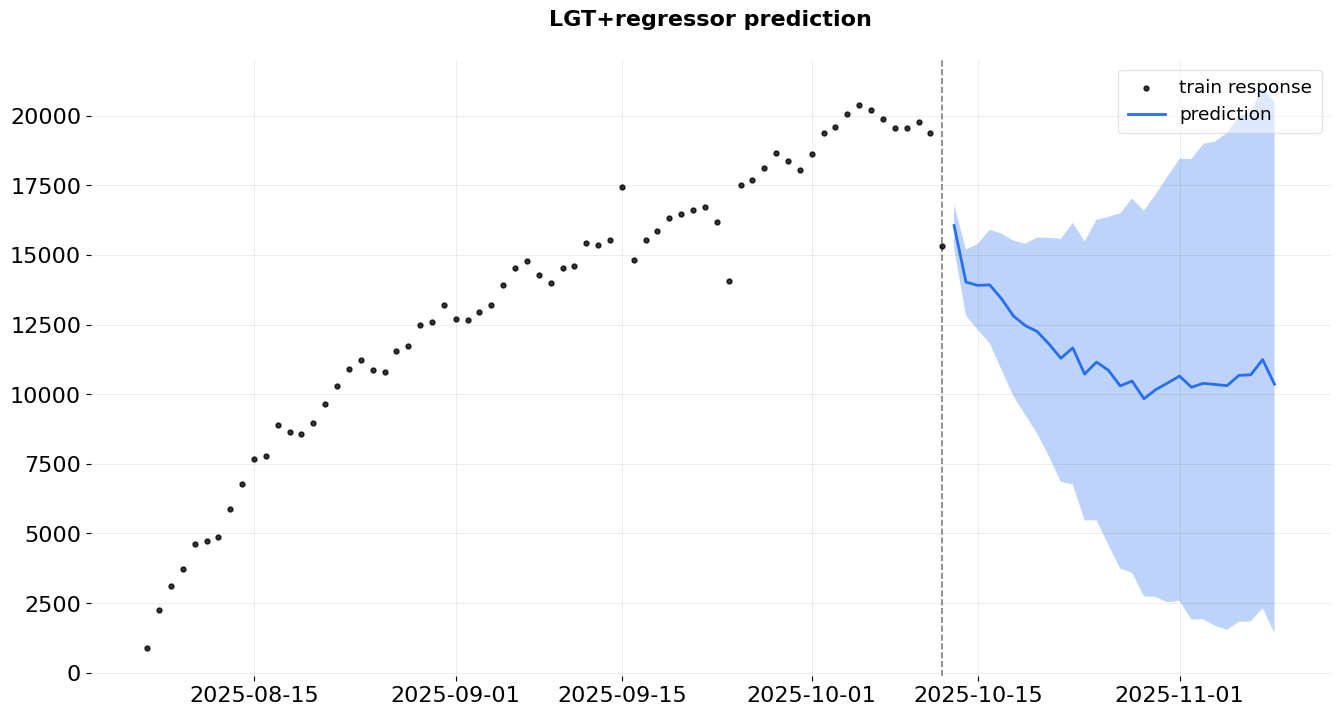

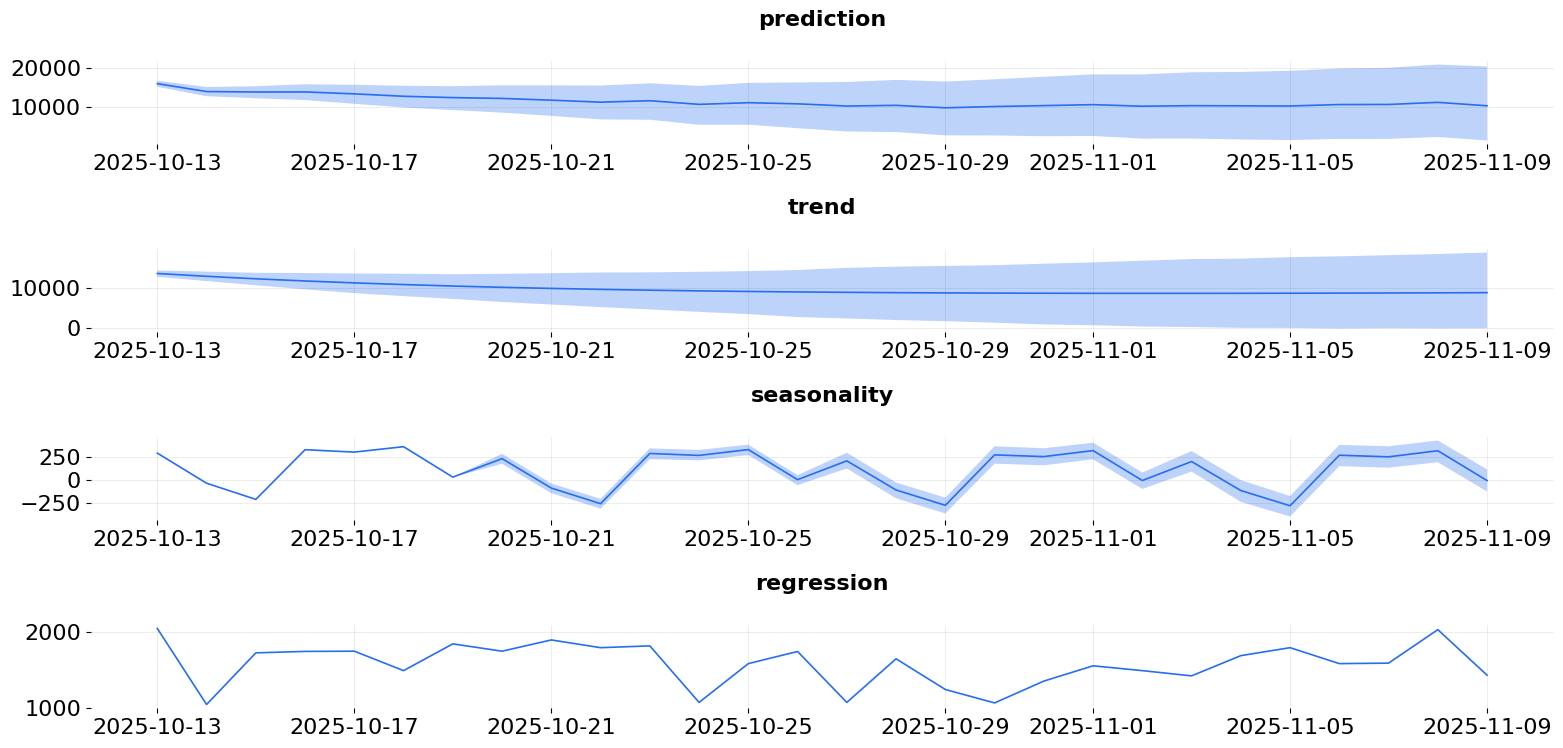

,metric_name,metric_values,is_training_metric
0,smape,6.249771e-02,False
1,wmape,6.142448e-02,False
2,mape,6.290670e-02,False
3,mse,1.727346e+06,False
4,mae,9.997132e+02,False
5,rmsse,1.251557e+00,False


In [ ]:
lgt_regr = LGT(response_col="DAU", #название колонки с метрикой
          date_col="date", #название колонки с датами-временем
          regressor_col= ["new_users"],
          seasonality=7, #длина периода сезонности
          estimator="stan-map", #алгоритм оценки
          n_bootstrap_draws=1000) #количество сэмплов бутстрапа для доверительного интервала

lgt_regr.fit(df)
future_df = lgt_regr.make_future_df(periods=7*4)
future_df = future_df.merge(regr, on='date', how='left') # добавляем колонку с регрессором в указанный файл через джойн и проверяем, что он появился
future_df['new_users'] = future_df['new_users'].astype(float) # переводим тип данных для возможности работы модели
predicted_lgt_regr = lgt_regr.predict(df=future_df, decompose=True) # прогнозируем данные с учетом регрессора

_ = plot_predicted_data(df,
                        predicted_lgt_regr,
                        "date",
                        'DAU',
                        title='LGT+regressor prediction')

_ = plot_predicted_components(predicted_lgt_regr,
                              "date",
                              plot_components=['prediction', 'trend', 'seasonality', 'regression'])

# оцениваем качество работы модели
bt_exp = BackTester(
    model = lgt_regr,
    df = df,
    min_train_len = 7*3,
    incremental_len = 2,
    forecast_len = 7,
    window_type = "expanding"
)
bt_exp.fit_predict()
bt_exp.score()

Модель также отреагировала на регрессор и изменила тренд на нисходящий. Ошибка слегка увеличилась (mape для LGT без регрессора = 5.925549e-02).

# Выводы

Посмотрим на предсказания некоторых моделей на одном графике

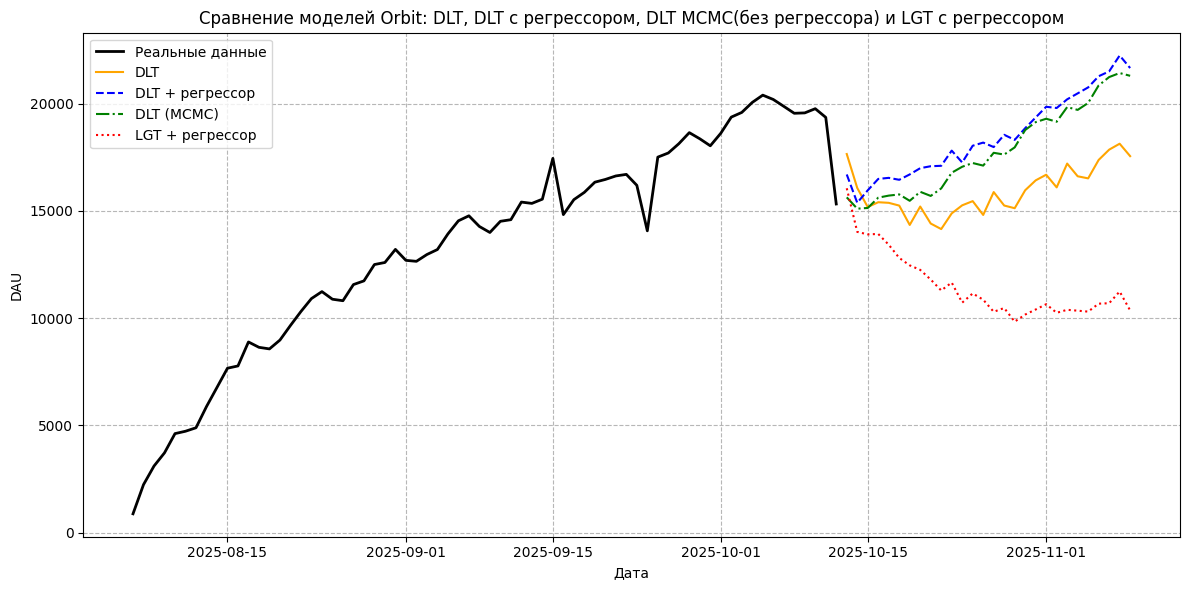

In [ ]:
plt.figure(figsize=(12, 6))

# фактические данные
plt.plot(df['date'], df['DAU'], label='Реальные данные', color='black', linewidth=2)

# предсказания моделей
plt.plot(predicted_dlt['date'], predicted_dlt['prediction'],
         label='DLT', linestyle='-', color='orange')


plt.plot(predicted_dlt_regr['date'], predicted_dlt_regr['prediction'],
         label='DLT + регрессор', linestyle='--', color='blue')

plt.plot(predicted_dlt_mc['date'], predicted_dlt_mc['prediction'],
         label='DLT (MCMC)', linestyle='-.', color='green')

plt.plot(predicted_lgt_regr['date'], predicted_lgt_regr['prediction'],
         label='LGT + регрессор', linestyle=':', color='red')

# оформление
plt.title("Сравнение моделей Orbit: DLT, DLT с регрессором, DLT MCMC(без регрессора) и LGT с регрессором")
plt.xlabel("Дата")
plt.ylabel("DAU")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()

1. В качестве основной метрики целесообразно выбрать DAU, так как от нее зависят все остальные показатели (действия) пользователей и нагрузка на серверы будет соответственно возрастать. Временное разрешение - один день. Регрессором может быть количество новых юзеров, так как оно может повлиять на DAU, и не зависит от нее.
2. Данных для прогнозирования на месяц вполне хватает - посчитанные ошибки моделей находятся в допустимых пределах.
3. В качестве основной модели я бы использовал DLT с регрессором, так как она устойчиво работает с нашими данными. Кроме того, ее результаты самые большие, а мы хотели бы знать максимально возможную загрузку нашего приложения. Судя по ее результатам количество новых юзеров может "пробить" 25000 в начале ноября, а это повышение на 25%, что может серьезно сказаться на работе наших серверов.